In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [38]:
for index, row in df.iterrows():
    if row['Country/Region'] == 'Others':
        a = row['Province/State']
        df.loc[index, 'Country/Region'] = a

In [39]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/5/20


,3/5/20
Country/Region,
Mainland China,80422
South Korea,6088
Italy,3858
Iran,3513
Diamond Princess cruise ship,706
Germany,482
France,377
Japan,360
Spain,259


In [40]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.9:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit **\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.9:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Curve Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' COVID-19 Cases as of '+mostrecentdate, fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror]
        else:
            return [edoubletime, edoubletimeerror]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror]



Mainland China

** Based on Logistic Fit **

	R^2: 0.993923070355
	Doubling Time:  3.23 (± 0.36 ) days


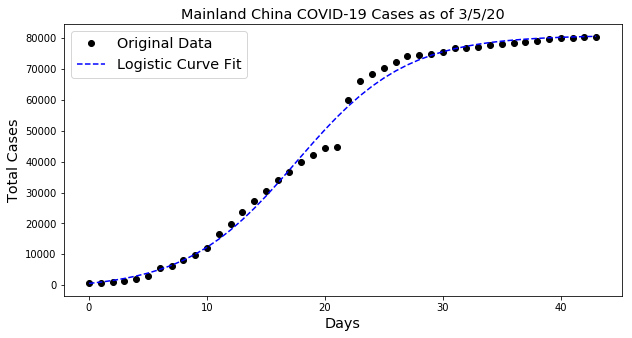



South Korea

** Based on Logistic Fit **

	R^2: 0.99913816851
	Doubling Time:  1.83 (± 0.08 ) days

** Based on Exponential Curve Fit **

	R^2: 0.98052504834
	Doubling Time:  3.82 (± 0.35 ) days


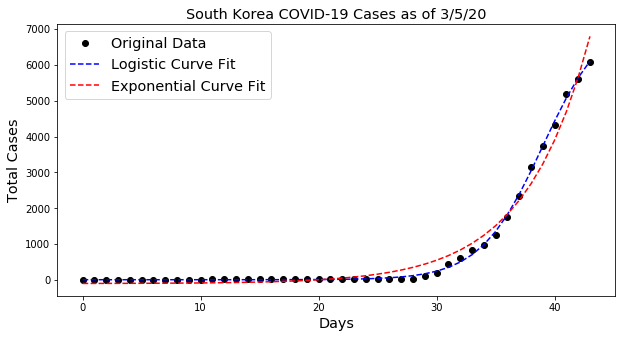



Italy

** Based on Logistic Fit **

	R^2: 0.998515825313
	Doubling Time:  2.01 (± 0.15 ) days

** Based on Exponential Curve Fit **

	R^2: 0.99463900282
	Doubling Time:  2.86 (± 0.15 ) days


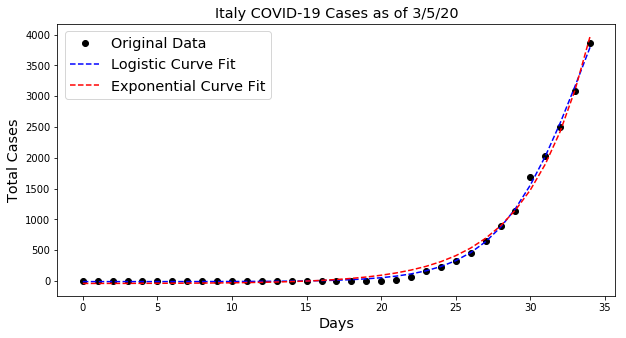



Iran

** Based on Logistic Fit **

	R^2: 0.99913428034
	Doubling Time:  1.1 (± 0.1 ) days

** Based on Exponential Curve Fit **

	R^2: 0.985517801669
	Doubling Time:  2.29 (± 0.37 ) days


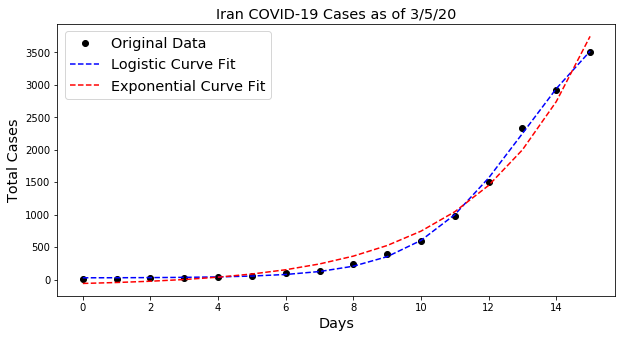



Diamond Princess cruise ship

** Based on Logistic Fit **

	R^2: 0.994979306647
	Doubling Time:  1.37 (± 0.18 ) days


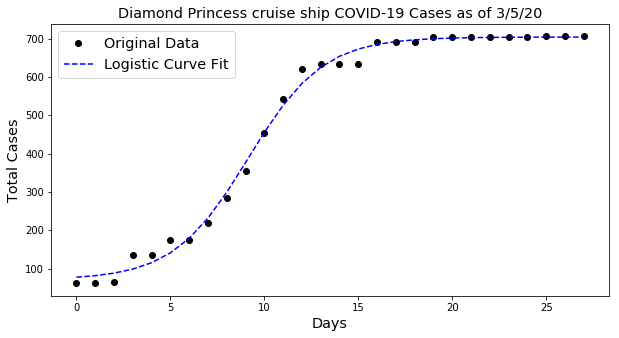



Germany

** Based on Exponential Curve Fit **

	R^2: 0.984562232479
	Doubling Time:  1.7 (± 0.14 ) days


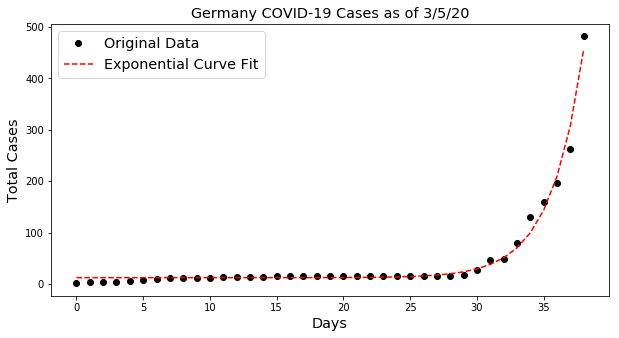



France

** Based on Exponential Curve Fit **

	R^2: 0.989046494514
	Doubling Time:  2.3 (± 0.16 ) days


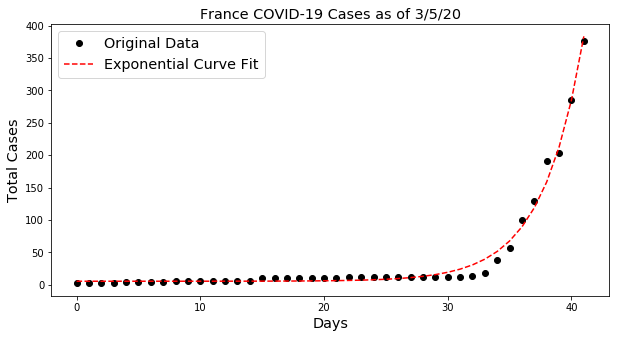



Japan

** Based on Logistic Fit **

	R^2: 0.993921449205
	Doubling Time:  4.54 (± 0.66 ) days

** Based on Exponential Curve Fit **

	R^2: 0.989469155012
	Doubling Time:  7.78 (± 0.65 ) days


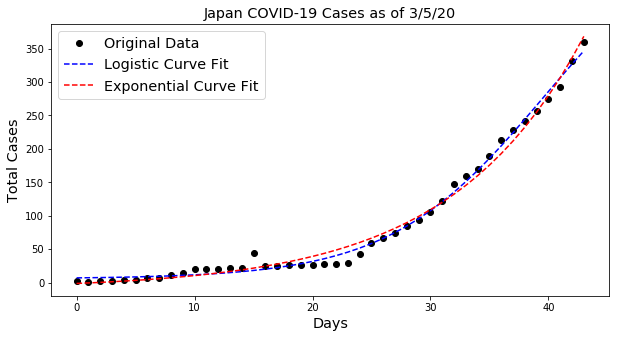



Spain

** Based on Exponential Curve Fit **

	R^2: 0.985334610677
	Doubling Time:  2.21 (± 0.2 ) days


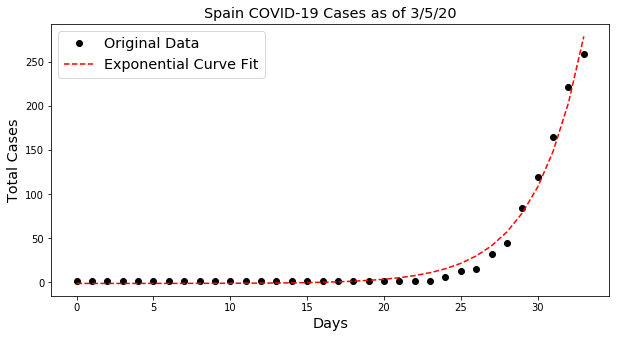



US

** Based on Exponential Curve Fit **

	R^2: 0.968303013952
	Doubling Time:  3.48 (± 0.41 ) days


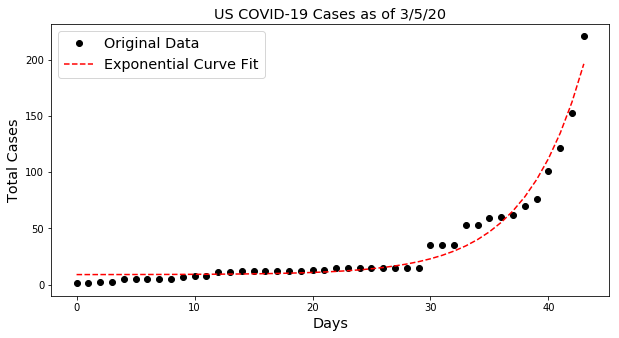



Singapore

** Based on Logistic Fit **

	R^2: 0.990868640896
	Doubling Time:  5.14 (± 0.91 ) days

** Based on Exponential Curve Fit **

	R^2: 0.962534500869
	Doubling Time:  36.03 (± 21.2 ) days


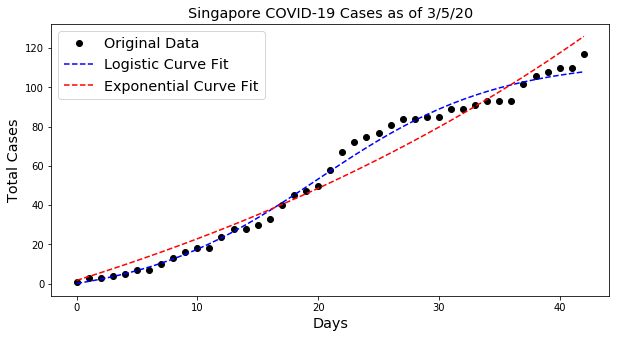



UK

** Based on Exponential Curve Fit **

	R^2: 0.982054393519
	Doubling Time:  1.93 (± 0.19 ) days


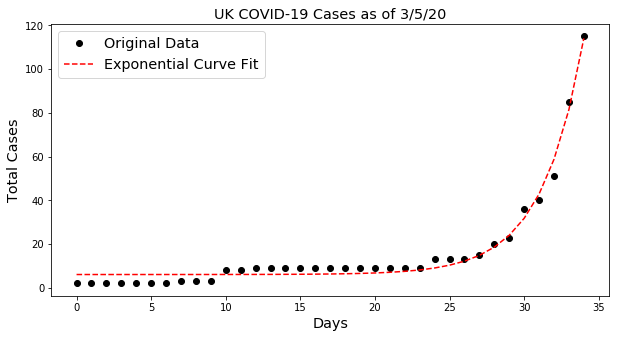



Switzerland

** Based on Logistic Fit **

	R^2: 0.995914485406
	Doubling Time:  1.45 (± 0.63 ) days

** Based on Exponential Curve Fit **

	R^2: 0.994275161271
	Doubling Time:  2.26 (± 0.4 ) days


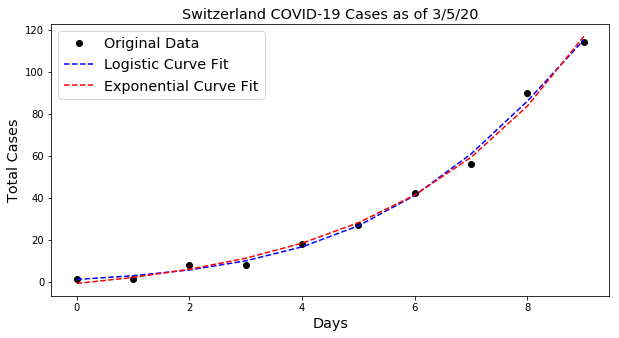



Hong Kong

** Based on Logistic Fit **

	R^2: 0.990274341583
	Doubling Time:  7.1 (± 1.81 ) days

** Based on Exponential Curve Fit **

	R^2: 0.983142811743
	Doubling Time:  38.13 (± 15.63 ) days


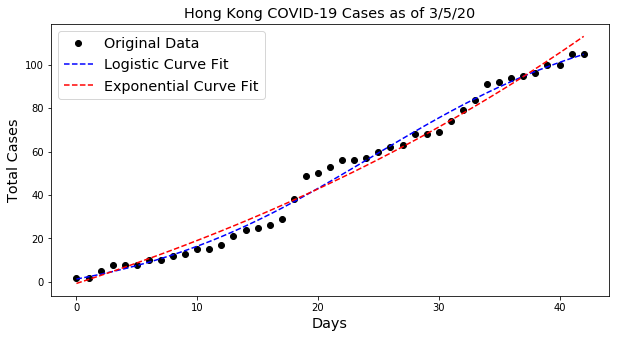

In [41]:
topcountries = cases.index
doublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

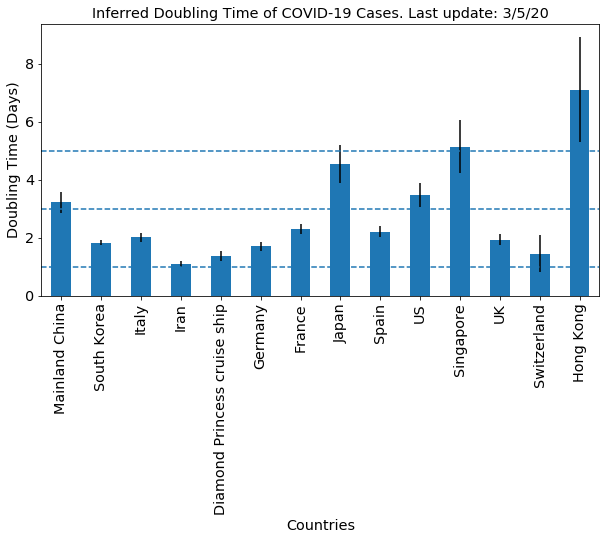

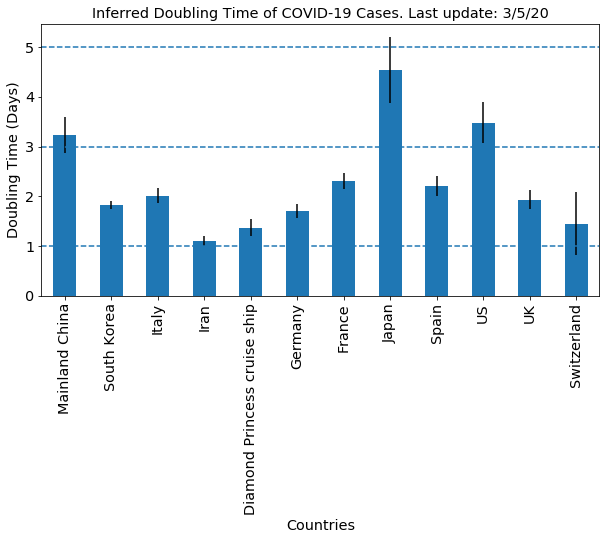

In [42]:
d = {'Countries': countries, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

In [43]:
uscases = df[df['Country/Region'] == 'US']

uscasesbystate = uscases.copy()
uscasesbystate['Province/State'] = uscasesbystate['Province/State'].str.split(", ", expand=True)[1]

usstatesummary = uscasesbystate.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/5/20


,3/5/20
Province/State,
WA,70
CA,51
NY,23
IL,5
FL,4
TX,4
OR,3
AZ,2
RI,2


In [44]:
uscitysummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = uscitysummary.columns[0]
uscitysummary = uscitysummary.sort_values(by = mostrecentdate, ascending = False)
uscitysummary = uscitysummary[uscitysummary[mostrecentdate] >= 5]

print('\nUS Locations with 5 or more confirmed cases as of', mostrecentdate)

uscitysummary


US Locations with 5 or more confirmed cases as of 3/5/20


,3/5/20
Province/State,
"King County, WA",51
Unassigned Location (From Diamond Princess),45
"Santa Clara, CA",20
"Snohomish County, WA",18
"Westchester County, NY",18
"Los Angeles, CA",11
"Cook County, IL",5




US state:  WA

** Based on Exponential Curve Fit **

	R^2: 0.994993368529
	Doubling Time:  1.37 (± 0.06 ) days


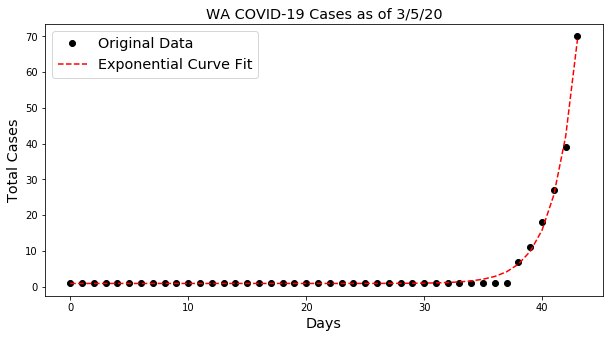



US state:  CA

** Based on Exponential Curve Fit **

	R^2: 0.934218270638
	Doubling Time:  1.83 (± 0.32 ) days


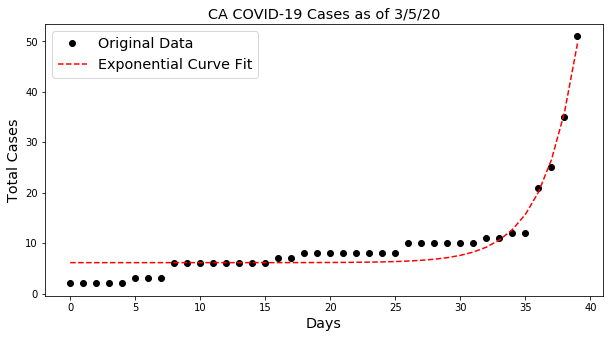

In [45]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 50]
print('\n');
doublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscasesbystate,'Province/State', state)
    if a:
        states.append(state)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

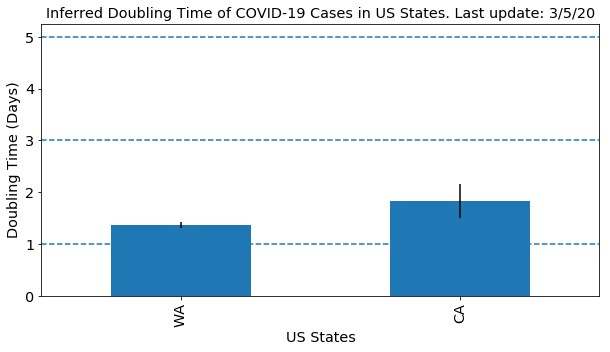

In [46]:
d = {'States': states, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'States', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()
